# Applying tf-idf with machine learning methods

This notebook applies feature engineering (tf-idf), and machine learning tools (knn, naive bayes, sgd, decision tree, random forest, XGBoost) on the training set to determine if each context contains a (non-ae) drug-ae pair.


In [1]:
# Name of train and test dataset
# Change according to test/train dataset chosen

train_worksheet = 'df_2009_us'# 2009 training set
test_worksheet = 'df_testing_all' # test set - 2010, 2011, MIMIC, MIMIC_unrestricted


In [2]:
# IMPORT PACKAGES
import re
import csv
import sys
import pickle
import time
import gensim
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook

from xgboost import XGBClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,SVR
from sklearn.naive_bayes import MultinomialNB, GaussianNB   
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Import data

Import the training and testing datasets

In [ ]:
# ***************** # IMPORT TRAINING DATASET
train_data = pd.read_excel(r'.\train undersampled.xlsx', sheet_name = train_worksheet)
train_data.head()

In [4]:
len(train_data)

1340

In [5]:
# ***************** # IMPORT TESTING DATASET
test_data = pd.read_excel(r'.\train and test processed.xlsx', sheet_name = test_worksheet)
print('length of test data: ', len(test_data))

length of test data:  6065


In [ ]:
test_data.head()

## Data cleaning

- remove stopwords
- stemming
- remove digits

We first define functions to clean the data, that can be applied across the 'context' column

In [7]:
# FUNCTIONS FOR DATA CLEANING

# remove stopwords
stop=set(stopwords.words('english'))
def remove_stopwords(text):
    if text is not None:
        tokens = [x for x in word_tokenize(text) if x not in stop]
        return " ".join(tokens)
    else:
        return None

# stemming
porter=PorterStemmer()
def stemSentence(text):
    token_words=word_tokenize(text)
    stem_sentence =[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

# remove digits
def remove_digits(text):
    digitpattern = '[0-9]'
    token_words=word_tokenize(text)
    digit_removed= [re.sub(digitpattern,'', i) for i in token_words]
    return " ".join(digit_removed)

train_data['segment_2']=train_data['segment_2'].apply(lambda x : remove_stopwords(x))
train_data['segment_2']=train_data['segment_2'].apply(lambda x : remove_digits(x))
train_data['segment_2']=train_data['segment_2'].apply(lambda x : stemSentence(x))

test_data['segment_2']=test_data['segment_2'].apply(lambda x : remove_stopwords(x))
test_data['segment_2']=test_data['segment_2'].apply(lambda x : remove_digits(x))
test_data['segment_2']=test_data['segment_2'].apply(lambda x : stemSentence(x))

In [8]:
# CONVERT TRAINING AND TESTING DATASET TO ARRAYS
train_x = train_data[['context','segment_2','drug','ae']]
train_y = train_data['label']
test_x = test_data[['context','segment_2','drug','ae']]
test_y = test_data['label']

In [9]:
train_x=train_x.values.tolist()
test_x=test_x.values
train_y=train_y.values.tolist()

## Tf-idf

We define 
- some functions to feed the training data into the tf-idf pipline
- functions to adjust class predictions based on the prediction thresholds
- functions to plot the precision recall curve
- functions to plot the f1 curve

After that, we inspect the predicted probabilities of the training data and determine an appropriate cutoff for various methods

In [10]:
# Wrapper function to fit the training data into the model#

def tfidf_pipeline_with(classifier, clf_name):            
    pipeline = Pipeline([('vect', CountVectorizer(stop_words=stopwords.words('english'))), 
                         ('tfidf',TfidfTransformer()),                      
                         ('clf', classifier),
                        ])
    pipeline.fit([row[1] for row in train_x], train_y)  ##change to row[1] which has the segment
    y_scores = pipeline.predict_proba([row[1] for row in train_x])[:,1]
    y_scores_test = pipeline.predict_proba([row[1] for row in test_x])[:,1]
    return y_scores, y_scores_test
    
# Wrapper function to adjust class predictions based on the prediction thresholds
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y>=t else 0 for y in y_scores]

# Wrapper function to plot the prediction recall curve
def precision_recall_threshold(p,r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(train_y, y_pred_adj),
                      columns=['pred_neg','pred_pos'],
                      index=['neg','pos']))  
    
    print("Classification report on testing set with adjusted threshold")
    print(classification_report(train_y,y_pred_adj))
    
    # plot the curve
    plt.figure(figsize =(4,4))
    plt.title("Precision and recall curve ^ = current threshold")
    plt.step(r,p, color="b", alpha=0.2, where="post")
    plt.fill_between(r,p, step = "post", alpha=0.2, color="b")
    plt.ylim([0.5,1.01]);
    plt.xlim([0.5,1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
          
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf],p[close_default_clf],'^',c='k',markersize=15)
    
# Wrapper function to plot the F1 by threshold curve          
def plot_f1_vs_threshold(f1, thresholds):
    plt.figure(figsize =(4,4))
    plt.title("F1 Score as a function of the decision threshold")
    plt.plot(thresholds,f1[:-1], "b--", label ="F1")
    plt.xlabel('Decision Threshold');
    plt.ylabel('Score');


### KNN Classifier

In [11]:
# get y_scores after training (probability of belonging in the '1' class)
results_from_pipeline=tfidf_pipeline_with(KNeighborsClassifier(n_neighbors=3,metric='euclidean' ),'KNN euclidean')
y_scores=results_from_pipeline[0]
y_scores_test=results_from_pipeline[1]

In [12]:
# get precision and recall at various thresholds
p, r, thresholds = precision_recall_curve(train_y, y_scores)

     pred_neg  pred_pos
neg       564       106
pos        60       610
Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       670
           1       0.85      0.91      0.88       670

   micro avg       0.88      0.88      0.88      1340
   macro avg       0.88      0.88      0.88      1340
weighted avg       0.88      0.88      0.88      1340



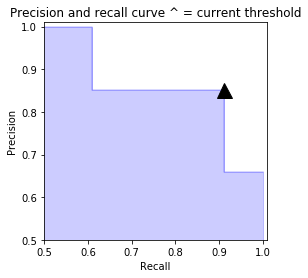

In [13]:
# plot the precision and recall curve, adjust the threshold to see the confusion matrix output at that threshold
precision_recall_threshold(p,r,thresholds, .5)

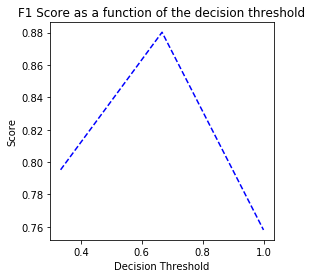

In [14]:
f1=2*(p*r)/(p+r) # calculate f1 score at each threshold

#plot f1 versus threshold
plot_f1_vs_threshold(f1, thresholds)

In [15]:
# set the optimal threshold
optimal_threshold = 0.5

# get the y scores for the testing set
y_pred_test = adjusted_classes(y_scores_test, optimal_threshold)
print("Confusion matrix on testing set with adjusted threshold")
print(pd.DataFrame(confusion_matrix(test_y, y_pred_test),
                      columns=['pred_neg','pred_pos'],
                      index=['neg','pos']))  
print("Classification report on testing set with adjusted threshold")
print(classification_report(test_y,y_pred_test))

# save results
prob_tfidf_knn=y_scores_test.tolist()
prob_tfidf_knn_train=y_scores.tolist()

Confusion matrix on testing set with adjusted threshold
     pred_neg  pred_pos
neg      2497      1537
pos       578      1453
Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       0.81      0.62      0.70      4034
           1       0.49      0.72      0.58      2031

   micro avg       0.65      0.65      0.65      6065
   macro avg       0.65      0.67      0.64      6065
weighted avg       0.70      0.65      0.66      6065



### Naive Bayes Classifier

In [16]:
# get y_scores after training (probability of belonging in the '1' class)
results_from_pipeline=tfidf_pipeline_with(MultinomialNB(alpha=0.05),'Naive Bayes')
y_scores=results_from_pipeline[0]
y_scores_test=results_from_pipeline[1]

In [17]:
# get precision and recall at various thresholds
p, r, thresholds = precision_recall_curve(train_y, y_scores)

     pred_neg  pred_pos
neg       638        32
pos         8       662
Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       670
           1       0.95      0.99      0.97       670

   micro avg       0.97      0.97      0.97      1340
   macro avg       0.97      0.97      0.97      1340
weighted avg       0.97      0.97      0.97      1340



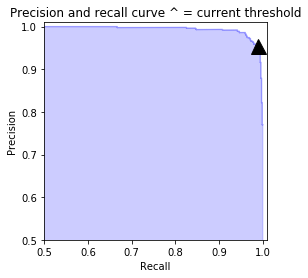

In [18]:
# plot the precision and recall curve, adjust the threshold to see the confusion matrix output at that threshold
precision_recall_threshold(p,r,thresholds, .5)

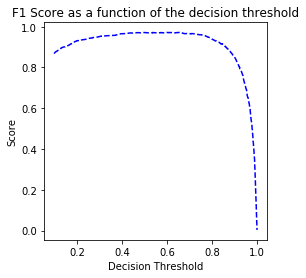

In [19]:
f1=2*(p*r)/(p+r) # calculate f1 score at each threshold

#plot f1 versus threshold
plot_f1_vs_threshold(f1, thresholds)

From the above graphs, the threshold that maximises F1 score is about 0.3, but to maximise recall, we choose a smaller threshold where all the positive cases get captured

In [20]:
# set the optimal threshold
optimal_threshold = 0.5

# get the y scores for the testing set
y_pred_test = adjusted_classes(y_scores_test, optimal_threshold)
print("Confusion matrix on testing set with adjusted threshold")
print(pd.DataFrame(confusion_matrix(test_y, y_pred_test),
                      columns=['pred_neg','pred_pos'],
                      index=['neg','pos']))  
print("\nClassification report on testing set with adjusted threshold")
print(classification_report(test_y,y_pred_test))

# save results
prob_tfidf_nb=y_scores_test.tolist()
prob_tfidf_nb_train=y_scores.tolist()

Confusion matrix on testing set with adjusted threshold
     pred_neg  pred_pos
neg      2985      1049
pos       648      1383

Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      4034
           1       0.57      0.68      0.62      2031

   micro avg       0.72      0.72      0.72      6065
   macro avg       0.70      0.71      0.70      6065
weighted avg       0.74      0.72      0.73      6065



### SGD Classifier

In [21]:
# get y_scores after training (probability of belonging in the '1' class)
results_from_pipeline=tfidf_pipeline_with(SGDClassifier(loss='log', max_iter=50, penalty='l2', alpha=1e-3, random_state=42, tol=None), 'SGD') 
y_scores=results_from_pipeline[0]
y_scores_test=results_from_pipeline[1]

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [22]:
# get precision and recall at various thresholds
p, r, thresholds = precision_recall_curve(train_y, y_scores)

     pred_neg  pred_pos
neg       630        40
pos        56       614
Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       670
           1       0.94      0.92      0.93       670

   micro avg       0.93      0.93      0.93      1340
   macro avg       0.93      0.93      0.93      1340
weighted avg       0.93      0.93      0.93      1340



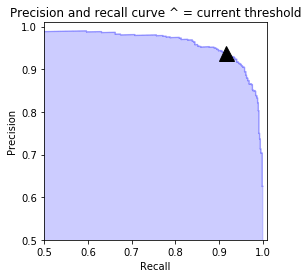

In [23]:
# plot the precision and recall curve, adjust the threshold to see the confusion matrix output at that threshold
precision_recall_threshold(p,r,thresholds, .5)

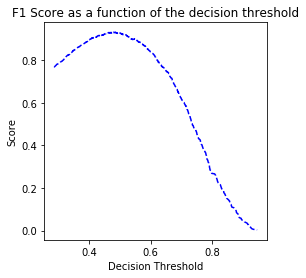

In [24]:
f1=2*(p*r)/(p+r) # calculate f1 score at each threshold

#plot f1 versus threshold
plot_f1_vs_threshold(f1, thresholds)

From the above graphs, the threshold that maximises F1 score is about 0.3, the recall is about 0.8 in the training set which is quite good. we will keep to 0.3

In [25]:
# set the optimal threshold
optimal_threshold = 0.5

# get the y scores for the testing set
y_pred_test = adjusted_classes(y_scores_test, optimal_threshold)
print("Confusion matrix on testing set with adjusted threshold")
print(pd.DataFrame(confusion_matrix(test_y, y_pred_test),
                      columns=['pred_neg','pred_pos'],
                      index=['neg','pos']))  
print("\nClassification report on testing set with adjusted threshold")
print(classification_report(test_y,y_pred_test))

# save results
prob_tfidf_sgd=y_scores_test.tolist()
prob_tfidf_sgd_train=y_scores.tolist()

Confusion matrix on testing set with adjusted threshold
     pred_neg  pred_pos
neg      3398       636
pos       727      1304

Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      4034
           1       0.67      0.64      0.66      2031

   micro avg       0.78      0.78      0.78      6065
   macro avg       0.75      0.74      0.74      6065
weighted avg       0.77      0.78      0.77      6065



### Decision Tree Classifier

In [26]:
# get y_scores after training (probability of belonging in the '1' class)
results_from_pipeline=tfidf_pipeline_with(DecisionTreeClassifier(random_state=2),'Decision Tree')   
y_scores=results_from_pipeline[0]
y_scores_test=results_from_pipeline[1]

In [27]:
# get precision and recall at various thresholds
p, r, thresholds = precision_recall_curve(train_y, y_scores)

     pred_neg  pred_pos
neg       669         1
pos         0       670
Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       670
           1       1.00      1.00      1.00       670

   micro avg       1.00      1.00      1.00      1340
   macro avg       1.00      1.00      1.00      1340
weighted avg       1.00      1.00      1.00      1340



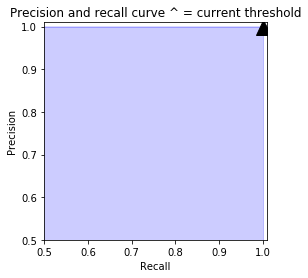

In [28]:
# plot the precision and recall curve, adjust the threshold to see the confusion matrix output at that threshold
precision_recall_threshold(p,r,thresholds, .5)

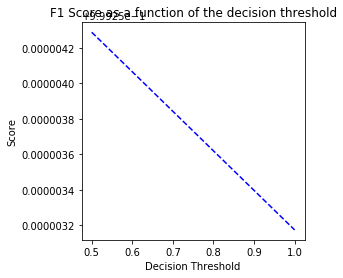

In [29]:
f1=2*(p*r)/(p+r) # calculate f1 score at each threshold

#plot f1 versus threshold
plot_f1_vs_threshold(f1, thresholds)

In [30]:
# set the optimal threshold
optimal_threshold = 0.5

# get the y scores for the testing set
y_pred_test = adjusted_classes(y_scores_test, optimal_threshold)
print("Confusion matrix on testing set with adjusted threshold")
print(pd.DataFrame(confusion_matrix(test_y, y_pred_test),
                      columns=['pred_neg','pred_pos'],
                      index=['neg','pos']))  
print("\nClassification report on testing set with adjusted threshold")
print(classification_report(test_y,y_pred_test))

# save results
prob_tfidf_dt=y_scores_test.tolist()
prob_tfidf_dt_train=y_scores.tolist()

Confusion matrix on testing set with adjusted threshold
     pred_neg  pred_pos
neg      2987      1047
pos       808      1223

Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      4034
           1       0.54      0.60      0.57      2031

   micro avg       0.69      0.69      0.69      6065
   macro avg       0.66      0.67      0.67      6065
weighted avg       0.70      0.69      0.70      6065



### Random Forest Classifier

In [31]:
# get y_scores after training (probability of belonging in the '1' class)
results_from_pipeline=tfidf_pipeline_with(RandomForestClassifier(random_state=5),'Random Forest')  
y_scores=results_from_pipeline[0]
y_scores_test=results_from_pipeline[1]

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [32]:
# get precision and recall at various thresholds
p, r, thresholds = precision_recall_curve(train_y, y_scores)

     pred_neg  pred_pos
neg       667         3
pos         2       668
Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       670
           1       1.00      1.00      1.00       670

   micro avg       1.00      1.00      1.00      1340
   macro avg       1.00      1.00      1.00      1340
weighted avg       1.00      1.00      1.00      1340



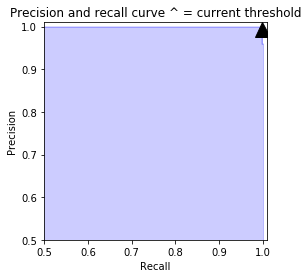

In [33]:
# plot the precision and recall curve, adjust the threshold to see the confusion matrix output at that threshold
precision_recall_threshold(p,r,thresholds, .5)

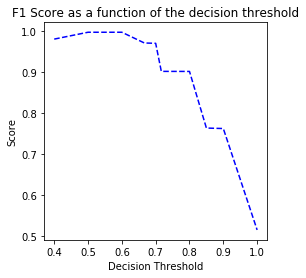

In [34]:
f1=2*(p*r)/(p+r) # calculate f1 score at each threshold

#plot f1 versus threshold
plot_f1_vs_threshold(f1, thresholds)

In [35]:
# set the optimal threshold
optimal_threshold = 0.5

# get the y scores for the testing set
y_pred_test = adjusted_classes(y_scores_test, optimal_threshold)
print("Confusion matrix on testing set with adjusted threshold")
print(pd.DataFrame(confusion_matrix(test_y, y_pred_test),
                      columns=['pred_neg','pred_pos'],
                      index=['neg','pos']))  
print("\nClassification report on testing set with adjusted threshold")
print(classification_report(test_y,y_pred_test))

# save results
prob_tfidf_rf=y_scores_test.tolist()
prob_tfidf_rf_train=y_scores.tolist()

Confusion matrix on testing set with adjusted threshold
     pred_neg  pred_pos
neg      3014      1020
pos       692      1339

Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      4034
           1       0.57      0.66      0.61      2031

   micro avg       0.72      0.72      0.72      6065
   macro avg       0.69      0.70      0.69      6065
weighted avg       0.73      0.72      0.72      6065



### XGBoost Classifier

In [36]:
# get y_scores after training (probability of belonging in the '1' class)
results_from_pipeline=tfidf_pipeline_with(GradientBoostingClassifier(random_state=8),'Extreme Gradient Boosting')  
y_scores=results_from_pipeline[0]
y_scores_test=results_from_pipeline[1]

In [37]:
# get precision and recall at various thresholds
p, r, thresholds = precision_recall_curve(train_y, y_scores)

     pred_neg  pred_pos
neg       629        41
pos        91       579
Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       670
           1       0.93      0.86      0.90       670

   micro avg       0.90      0.90      0.90      1340
   macro avg       0.90      0.90      0.90      1340
weighted avg       0.90      0.90      0.90      1340



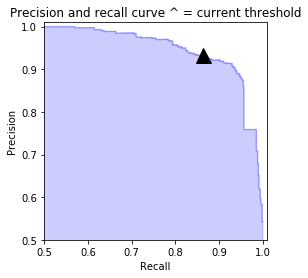

In [38]:
# plot the precision and recall curve, adjust the threshold to see the confusion matrix output at that threshold
precision_recall_threshold(p,r,thresholds, .5)

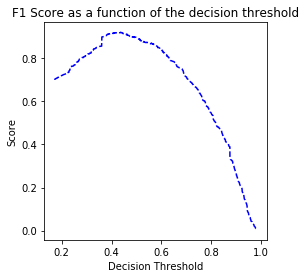

In [39]:
f1=2*(p*r)/(p+r) # calculate f1 score at each threshold

#plot f1 versus threshold
plot_f1_vs_threshold(f1, thresholds)

In [40]:
# set the optimal threshold
optimal_threshold = 0.5

# get the y scores for the testing set
y_pred_test = adjusted_classes(y_scores_test, optimal_threshold)
print("Confusion matrix on testing set with adjusted threshold")
print(pd.DataFrame(confusion_matrix(test_y, y_pred_test),
                      columns=['pred_neg','pred_pos'],
                      index=['neg','pos']))  
print("\nClassification report on testing set with adjusted threshold")
print(classification_report(test_y,y_pred_test))

# save results
prob_tfidf_xgb=y_scores_test.tolist()
prob_tfidf_xgb_train=y_scores.tolist()

Confusion matrix on testing set with adjusted threshold
     pred_neg  pred_pos
neg      3371       663
pos       942      1089

Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      4034
           1       0.62      0.54      0.58      2031

   micro avg       0.74      0.74      0.74      6065
   macro avg       0.70      0.69      0.69      6065
weighted avg       0.73      0.74      0.73      6065



## Combine results to a dataframe and save to excel

In [41]:
# Combine results to dataframe

tfidf_results_train = pd.DataFrame({'context':train_data['context'].tolist(),
                              'segment_2':train_data['segment_2'].tolist(),
                              'drug':train_data['drug'].tolist(),
                              'ae':train_data['ae'].tolist(),
                              'label':train_data['label'].tolist(),
                             'prob_tfidf_nb':prob_tfidf_nb_train,
                             'prob_tfidf_knn':prob_tfidf_knn_train,
                             'prob_tfidf_sgd':prob_tfidf_sgd_train,
                             'prob_tfidf_dt':prob_tfidf_dt_train,
                             'prob_tfidf_rf':prob_tfidf_rf_train,
                             'prob_tfidf_xgb':prob_tfidf_xgb_train
                             })


tfidf_results_test = pd.DataFrame({'source':test_data['source'].tolist(),
                                'context':test_data['context'].tolist(),
                              'segment_2':test_data['segment_2'].tolist(),
                              'drug':test_data['drug'].tolist(),
                              'ae':test_data['ae'].tolist(),
                              'label':test_data['label'].tolist(),
                             'prob_tfidf_nb':prob_tfidf_nb,      
                             'prob_tfidf_knn':prob_tfidf_knn,
                             'prob_tfidf_sgd':prob_tfidf_sgd,
                             'prob_tfidf_dt':prob_tfidf_dt,
                             'prob_tfidf_rf':prob_tfidf_rf,
                             'prob_tfidf_xgb':prob_tfidf_xgb
                             })


In [42]:
book=load_workbook(r'./results_external_tfidf.xlsx')
writer = pd.ExcelWriter(r'./results_external_tfidf.xlsx', engine = 'openpyxl')
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
tfidf_results_train.to_excel(writer, sheet_name = train_worksheet, index=False)
tfidf_results_test.to_excel(writer, sheet_name = test_worksheet, index=False)

writer.save()